In [1]:
import joblib
import sys
import pathlib
import yaml
import subprocess

import numpy as np
import tensorflow as tf
from tensorflow.keras.losses import CategoricalCrossentropy, MeanSquaredError

from buddi_data import BuDDIData

2025-04-16 09:49:43.812561: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-16 09:49:43.822722: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744818583.833105  262345 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744818583.836245  262345 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744818583.845305  262345 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
SAMPLE_ID_COL = 'sample_id'
STIM_COL = 'stim'
TECH_COL = 'samp_type'
DATASPLIT_COL = 'isTraining'

GENE_ID_COL = 'gene_ids'

In [3]:
# Get the root directory of the analysis repository
REPO_ROOT = subprocess.run(
    ["git", "rev-parse", "--show-toplevel"], capture_output=True, text=True
).stdout.strip()
REPO_ROOT = pathlib.Path(REPO_ROOT)

CONFIG_FILE = REPO_ROOT / 'config.yml'
assert CONFIG_FILE.exists(), f"Config file not found at {CONFIG_FILE}"

with open(CONFIG_FILE, 'r') as file:
    config_dict = yaml.safe_load(file)

In [4]:
buddi_fork_path = config_dict['software_path']['buddi_HGSC']
buddi_fork_path = pathlib.Path(buddi_fork_path)
assert buddi_fork_path.exists(), f"buddi fork not found at {buddi_fork_path}"

sys.path.insert(0, str(buddi_fork_path))
from buddi.models.buddi4 import build_buddi4
from buddi.models.components.layers import ReparameterizationLayer

I0000 00:00:1744818585.250664  262345 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4305 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


### Validation Output plot path

In [5]:
VALIDATION_OUTPUT = pathlib.Path('.').absolute() / 'validation_output'
VALIDATION_OUTPUT.mkdir(exist_ok=True)

### Train model weight and data

In [6]:
TRAINED_MODELS_PATH = REPO_ROOT / 'trained_models'
TRAIN_DATA_FILE = REPO_ROOT / 'processed_data' / 'train_data.pkl'

### Data

In [7]:
train_data = joblib.load(TRAIN_DATA_FILE)

n_x = len(train_data.gene_names)
n_y = len(train_data.cell_type_names)
n_labels = train_data.encode_meta[SAMPLE_ID_COL].shape[1]
n_stims = train_data.encode_meta[STIM_COL].shape[1]
n_samp_types = train_data.encode_meta[TECH_COL].shape[1]

## Validate

In [8]:
from validation.perturb_latent_space import perturb_z_branch
from validation.resampling import ResamplingDecoder
from validation.utils import integrate_over, _int_z
from validation.plot_validation import plot_resampled_latent_space

In [9]:
supervised_buddi, unsupervised_buddi, supervised_decoder, unsupervised_decoder = build_buddi4(
        n_x=n_x,
        n_y=n_y,
        n_labels=n_labels,
        n_stims=n_stims,
        n_samp_types=n_samp_types,
        reconstr_loss_fn = MeanSquaredError, # the loss function does not matter unless training further
        classifier_loss_fn = CategoricalCrossentropy, # the loss function does not matter unless training further
        return_decoder = True
    )

model_type = 'buddi4'
model_z_beta = '10.0'

model_string = f'{model_type}_beta_{model_z_beta}'

supervised_buddi.load_weights(
        TRAINED_MODELS_PATH / f'{model_type}_beta_{model_z_beta}_supervised_model.keras'
    )
unsupervised_buddi.load_weights(
    TRAINED_MODELS_PATH / f'{model_type}_beta_{model_z_beta}_unsupervised_model.keras'
)

/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 82 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [10]:
# Forward Pass To Obtain Latent Space of the bulks
x_unkp = train_data.X_unkp
y_unkp = train_data.y_unkp #dummy value
meta_unkp = train_data.meta_unkp

pred = unsupervised_buddi((x_unkp))
x_reconst, z_label, z_stim, z_samp_type, z_slack, _, _, _, y_hat = pred

/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['X']
Received: inputs=Tensor(shape=(588, 7000))
  warnings.warn(msg)


In [11]:
from sklearn.model_selection import train_test_split

meta_unkp.reset_index(drop=True, inplace=True)

# Select a random sample stratified by 'stim'
meta_unkp_sampled, _ = train_test_split(
    meta_unkp,
    test_size=0.95,  # Adjust the test size as needed
    stratify=meta_unkp['stim'],
    random_state=42  # For reproducibility
)

meta_unkp_sampled

,sample_id,stim,samp_type,isTraining,cell_prop_type,cell_type
71,20160X193,white,bulk,Train,bulk,bulk
264,19291X29,black,bulk,Train,bulk,bulk
199,20160X292,white,bulk,Train,bulk,bulk
97,18341X38,black,bulk,Train,bulk,bulk
357,20160X56,white,bulk,Train,bulk,bulk
243,19291X139,black,bulk,Train,bulk,bulk
25,20160X4,white,bulk,Train,bulk,bulk
4,20160X53,white,bulk,Train,bulk,bulk
112,20160X88,white,bulk,Train,bulk,bulk
284,19291X182,black,bulk,Train,bulk,bulk


In [19]:
import pandas as pd

y_int = integrate_over(
    y=y_hat.numpy()[meta_unkp_sampled.index],
)
y_int_tile = tf.convert_to_tensor(
    np.tile(y_int, (len(meta_unkp_sampled),1)), dtype=tf.float32)
print(y_int_tile.shape)
              

resampling_decoder = ResamplingDecoder(
    decoder=supervised_decoder,
    n_y=n_y,
    z_shape={
        SAMPLE_ID_COL: 64,
        STIM_COL: 64,
        TECH_COL: 64,
        'slack': 64,
    },
    _reparam_layer=ReparameterizationLayer(),
)

n_resamples = 20
xs_resamp = []
metas_resamp = []
for _ in range(n_resamples):

    with tf.device('/CPU:0'):
        _x_resamp = resampling_decoder(
            (y_int_tile,
            z_label.numpy()[meta_unkp_sampled.index], 
            z_stim.numpy()[meta_unkp_sampled.index], 
            z_samp_type.numpy()[meta_unkp_sampled.index], 
            z_slack.numpy()[meta_unkp_sampled.index])
        )
    xs_resamp.append(_x_resamp.numpy())
    metas_resamp.append(meta_unkp_sampled)

x_resamp_int_y = np.concatenate(xs_resamp, axis=0)
meta_resamp_int_y = pd.concat(metas_resamp, axis=0)
print(x_resamp_int_y.shape)

(29, 11)
(580, 7000)


In [13]:
# subsample_idx = np.random.choice(
#     np.arange(x_unkp.shape[0]),
#     size=500,
#     replace=False
# )

x_perturb, meta_perturb = perturb_z_branch(
    decoder=supervised_decoder,
    z_param_dict={
        SAMPLE_ID_COL: z_label,
        STIM_COL: z_stim,
        TECH_COL: z_samp_type,
        'z_slack': z_slack
    },
    z_to_perturb=SAMPLE_ID_COL,
    y=y_int_tile,
    int_over_y=True,
    int_over_z=True,
    metadata=meta_unkp,
    n_resamples=5,
    idx=meta_unkp_sampled.index,
    _reparam_layer=ReparameterizationLayer()
)
print(x_perturb.shape)

(4060, 7000)


In [42]:
meta_perturb_merged_meta = meta_perturb.merge(
    meta_unkp[['sample_id', 'stim']],
    on='sample_id',
    how='left'
)

/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


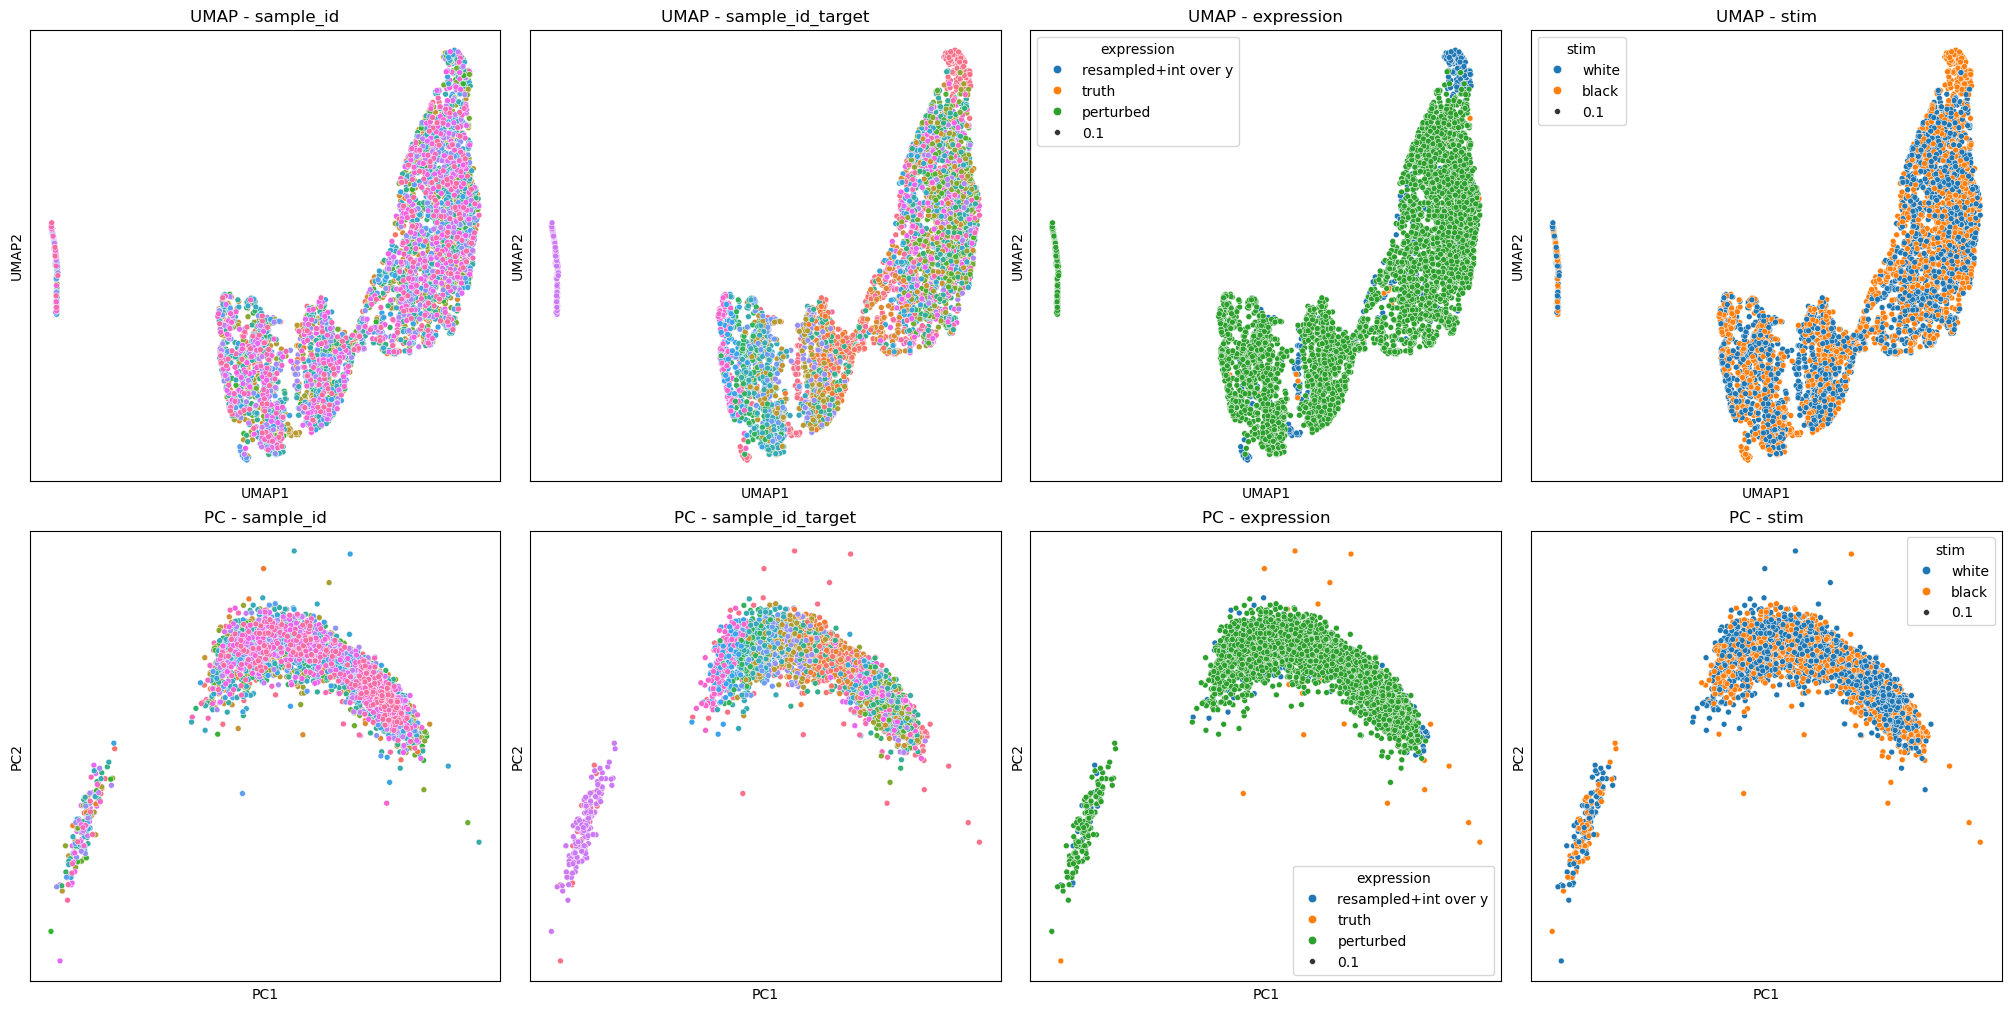

In [46]:
import pandas as pd
_x = np.concatenate(
    [
        x_resamp_int_y,
        x_unkp[meta_unkp_sampled.index,:],
        x_perturb
    ],
    axis=0
)

meta_resamp_int_y.loc[:, [f'{SAMPLE_ID_COL}_target']] = 'unperturbed'
meta_resamp_int_y.loc[:, ['expression']] = 'resampled+int over y'

_meta = meta_unkp_sampled.loc[:, [SAMPLE_ID_COL, STIM_COL]].copy()
_meta.loc[:, [f'{SAMPLE_ID_COL}_target']] = 'unperturbed'
_meta.loc[:, ['expression']] = 'truth'

meta_perturb_merged_meta.loc[:, ['expression']] = 'perturbed'

_meta = pd.concat(
    [
        meta_resamp_int_y,
        _meta,
        meta_perturb_merged_meta
    ]
)

plot_resampled_latent_space(
    x=_x,
    metadata=_meta,
    color_by=['sample_id', 'sample_id_target', 'expression', 'stim'],
    use_umap=True,
    show_plot=True
)

In [32]:
perturb_select_idx = np.intersect1d(
    np.where(meta_perturb_merged_meta['sample_id'] == '20160X193'),
    np.where(meta_perturb_merged_meta['sample_id_target'] == '19291X29')
)

In [41]:
meta_perturb_merged_meta.iloc[perturb_select_idx,:]

,sample_id,sample_id_target,expression,stim
0,20160X193,19291X29,reconstructed,white
1,20160X193,19291X29,reconstructed,white
2,20160X193,19291X29,reconstructed,white
3,20160X193,19291X29,reconstructed,white
4,20160X193,19291X29,reconstructed,white


/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


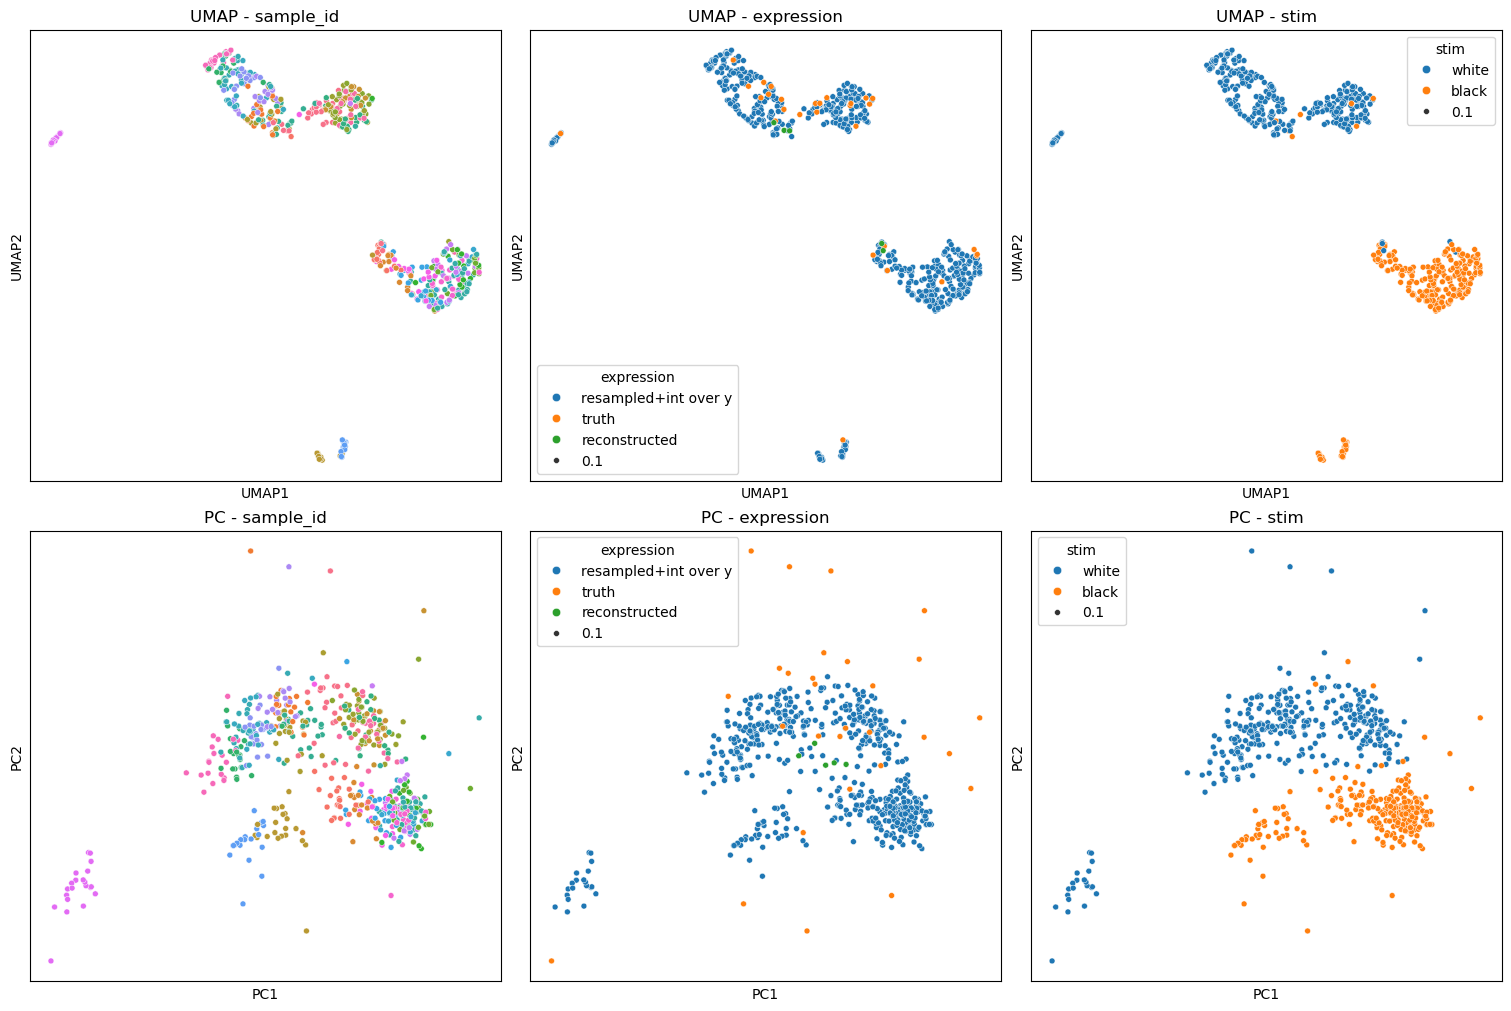

In [34]:
_x_sub = x_unkp[meta_unkp_sampled.index,:]
_meta_sub = meta_unkp_sampled.copy()
_meta_sub.loc[:, ['expression']] = 'truth'

_meta_resamp_int = meta_resamp_int_y.copy()
_meta_resamp_int.loc[:, ['expression']] = 'resampled+int over y'

plot_resampled_latent_space(
    x=np.concatenate(
        [
            x_resamp_int_y,
            _x_sub,
            x_perturb[perturb_select_idx,:]
        ],
        axis=0
    ),
    metadata=pd.concat(
        [
            _meta_resamp_int,
            _meta_sub,
            meta_perturb_merged_meta.iloc[perturb_select_idx,:]
        ],
        axis=0
    ),
    color_by=['sample_id', 'expression', 'stim'],
    use_umap=True,
    show_plot=True
)

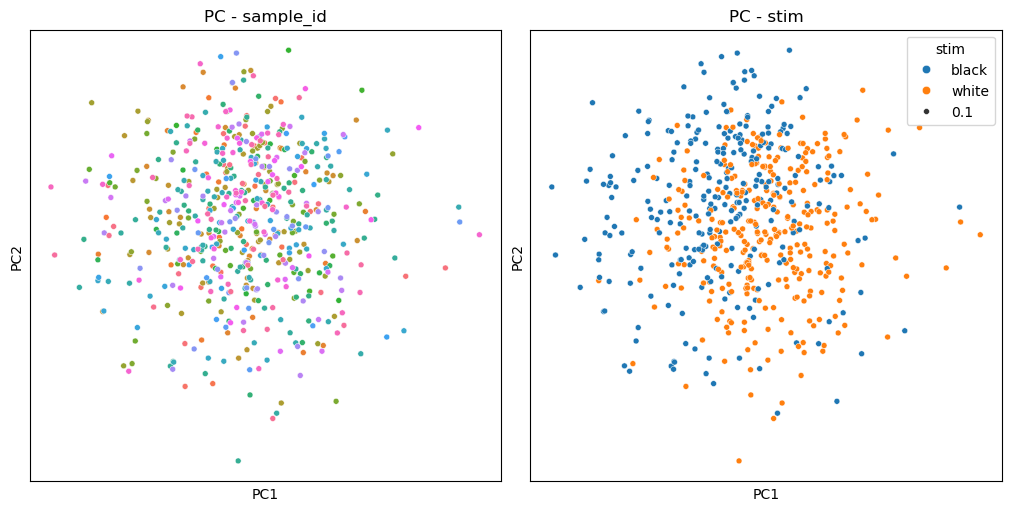

In [18]:
plot_resampled_latent_space(
    x=x_unkp,
    metadata=meta_unkp,
    color_by=['sample_id', 'expression', 'stim'],
    use_umap=False,
    show_plot=True
)